# Model evaluations

In [108]:
import pandas as pd
import numpy as np
import json
import os
import re
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shutil

In [125]:
MODEL_OUTPUT = "experiments_old/"

In [126]:
def parse_model_name(model: str):
    """  
    Takes model name of form "model_bert_base_multilingual_cased_max_sequence_length_512_epochs_3_run_multilingual_1"
    and parses it into dictionary 
    :return: dictionary with keys: dict_keys(['model', 'max_sequence_length', 'epochs', 'suffix', 'language', 'run'])
    """
    params = dict()
    params["model"] = re.findall(r"model_(.*)_max", model)[0]
    params["max_sequence_length"] = re.findall(r"max_sequence_length_([0-9]*)_epochs", model)[0]
    params["epochs"] = re.findall(r"epochs_([0-9]*)", model)[0]
    params["suffix"] = re.findall(r"epochs_[0-9](.*)", model)[0]
    
    try:
        #if suffix of form "run_de_1" or "run_multilingual-de_1"
        params["language"] = re.findall(r"run_([a-z\-]*)_", model)[0]
        params["run"] = int(re.findall(r"run_[a-z\-]*_([0-9]*)", model)[0])
    except:
        #if suffix of form "_de"
        params["language"] = re.findall(r"_([a-z\-]*)", model)[-1]
        params["run"] = None
    return params



def parse_global_data(metrics_dict: dict[str, float], model_name: str):
    """  
    Takes a dictionary with metric scores and a model name and outputs everything as Dataframe.

    Parameters:
    :metrics_dict: dictionary with metrics, e.g. {'loss': 0.06, 'precision': 0.73, 'recall': 0.85, 'f1': 0.79}
    :model_name: str, name of the model the metrics belong to

    :return: pd.DataFrame with 1 row, with columns = ['model', 'max_sequence_length', 'epochs', 'suffix', 'language', 'run'] + 
                                                    all keys from global_dict
    """
    final_dict = parse_model_name(model_name)
    final_dict.update(metrics_dict)
    return pd.DataFrame(final_dict, index=[0])



def parse_class_report(report: str):
    """  
    Parse detailed class report

    Parameters:
    :report: class report, in the form of one string; rows split with \n

    :return: pd.DataFrame of class report    
    """
    #split data in rows
    all_rows = [entry.strip() for entry in report.split("\n")]
    rows = [entry for entry in all_rows if entry]

    #get header
    header = ["label"]
    header +=  re.findall(r"([^\s]+)", rows[0].replace("-score", ""))
    rows = rows[1:]

    #parse values per row and save them in "data"
    data = []
    for row in rows:
        row = row.replace(" avg", "_avg")
        row = row.replace("accuracy", "accuracy _ _")
        data.append(re.findall(r"([^\s]+)", row))
    return pd.DataFrame(data=data, columns=header)



def parse_all_class_reports(report_list: list[str]):
    """  
    Parse a list of class reports
    
    Parameters:
    :report_list: list of class reports, one class report as string

    :return: list of pd.DataFrame, one df per class report
    """
    all_reports = []
    for report in report_list:
        all_reports.append(parse_class_report(report))
    return all_reports

# Import Results

In [127]:
ne_global_metrics = pd.DataFrame()
ne_dev_metrics = dict()
ne_test_metrics = dict()
sent_dev_metrics = dict()
sent_test_metrics = dict()

for model in os.listdir(MODEL_OUTPUT):
    #ignore everything which is not an experiments folder
    if not os.path.isdir(os.path.join(MODEL_OUTPUT, model)):
        continue
    
    result_files = [ x for x in os.listdir(os.path.join(MODEL_OUTPUT, model)) if "all_results" in x ]
    
    #if model folder exists, but no json (results) file in the folder
    if not result_files:
        print("Was not able to get results for model:", model)
        continue
    

    #for all json (results) files, parse results and save them in the dataframe/dictionaries
    for file in result_files:
        filepath = os.path.join(MODEL_OUTPUT, model, file)

        modelname = model
        #if trained multilingual, but evaluated separately for fr and de, need to store language information 
        if "run_multilingual" in modelname:
            try:
                lang = re.findall(r"all_results_([a-z]+).json", file)[0]
            except:
                print("Was not able to infer language from files in:" , modelname)
            modelname = modelname.replace("run_multilingual", f"run_multilingual-{lang}")

        with open(filepath, "r") as f:
            model_res = json.load(f)

            #parse data and save it in different formats    
            try:
                #if several dev results, take last one
                dev_global = parse_global_data(model_res["dev"]["global"][-1], modelname)
                ne_dev_metrics[modelname] = parse_class_report(model_res["dev"]["token-level"][-1])
                sent_dev_metrics[modelname] = parse_class_report(model_res["dev"]["sent-level"][-1])
            except:
                dev_global = parse_global_data(model_res["dev"]["global"], modelname)
                ne_dev_metrics[modelname] = parse_class_report(model_res["dev"]["token-level"])
                sent_dev_metrics[modelname] = parse_class_report(model_res["dev"]["sent-level"])
            dev_global.insert(4, "set", "dev") #insert column at 5th position

            test_global = parse_global_data(model_res["test"]["global"], modelname)          
            test_global["set"] = "test"
            
            ne_global_metrics = pd.concat([ne_global_metrics, dev_global, test_global], ignore_index=True)
            ne_test_metrics[modelname] = parse_class_report(model_res["test"]["token-level"])
            sent_test_metrics[modelname] = parse_class_report(model_res["test"]["sent-level"])
        
#change str to int       
ne_global_metrics["max_sequence_length"] = ne_global_metrics["max_sequence_length"].astype(int)
ne_global_metrics["epochs"] = ne_global_metrics["epochs"].astype(int)

Was not able to get results for model: model_xlm_roberta_base_max_sequence_length_256_epochs_3_run_de_4
Was not able to infer language from files in: model_bert_base_multilingual_cased_max_sequence_length_256_epochs_3_run_multilingual_3
Was not able to get results for model: model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_64_epochs_3_run_fr_4
Was not able to get results for model: model_xlm_roberta_base_max_sequence_length_128_epochs_3_run_de_2
Was not able to get results for model: model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_256_epochs_3_run_multilingual_2
Was not able to get results for model: model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_128_epochs_3_run_fr_2
Was not able to get results for model: model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_256_epochs_3_run_fr_5
Was not able to get results for model: model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_64_epochs_3_run_f

## Plotting Function

In [122]:
def plot_results(orig_df, languages: list[str], columns=["model", "max_sequence_length", "language"], score="f1"):
    """ 
    Plots results of different models from orig_df.

    Parameters:
    :orig_df: pd.DataFrame with results. Should have score-column with subcolumns "mean" and "std"
    :languages: languages to plot, e.g. ["de", "multilingual-de"]
    :columns: columns which define models
    :score: score which should be evaluated
    """
    df = orig_df.copy()
    df = df[df["language"].isin(languages)]
    models = df[columns[0]].str.cat(df[columns[1:]].values.astype(str),sep='_')
    y = df[score]["mean"]
    y_err = df[score]["std"]
    color_dict = {"de": "r",
                "fr": "g",
                "multilingual-de": "brown",
                "multilingual-fr": "darkslategrey"}
    
    colors = [color_dict[lang] for lang in df["language"] ]
    size = df["max_sequence_length"].astype(int).tolist()

    
    #save model name each time it changes (x), alternating true-false list per model (bo)
    x, bo = [], []
    modelname = None
    flag = False
    for model in df["model"]:
        if modelname != model:
            flag = not flag
            modelname = model
            x.append(model)
        else:
            x.append("")
        bo.append(flag)

    #include a space between two models
    n_x, n_y, n_y_err, n_models, n_size, n_colors, n_bo = [], [], [], [], [], [], []
    for ix, iy, iy_err, imodels, isize, icolors, ibo in zip(x, y, y_err, models, size, colors, bo):
        if ix != "":
            n_x.append("")
            n_y.append(0)
            n_y_err.append(0)
            n_models.append(ix + "_gap")
            n_size.append(64)
            n_colors.append("white")
            n_bo.append(True)

        n_x.append(ix)
        n_y.append(iy)
        n_y_err.append(iy_err)
        n_models.append(imodels)
        n_size.append(isize)
        n_colors.append(icolors)
        n_bo.append(ibo)

    n_x = [x.replace("_", "\n") for x in n_x]
    #position x axis labels at the middle for each model
    x_pos_dict = {x: i for i, x in enumerate(n_x) if x != ""}
    pos_l = list(x_pos_dict.values())
    pos_l.append(len(n_x))
    #get position where model name should be placed
    x_pos = [pos_l[i] + int((pos_l[i+1] - pos_l[i])/2) for i in range(len(pos_l)-1)]
    n_x = [""] * len(n_x)
    #place model name
    for i, model in enumerate(x_pos_dict.keys()):
        n_x[x_pos[i]] = model


    ##################
    #plotting

    fig, ax = plt.subplots(1, 1, figsize=(16,8))
    #std 
    ax.errorbar(n_models, n_y, yerr=n_y_err, ls='none')
    #mean
    sc = plt.scatter(n_models, n_y, c=n_colors, s=n_size)
    plt.scatter(n_models, n_y, c="black", marker=".")

    #change background based on models
    ax.fill_between(n_models, 1, 0, where=n_bo, facecolor='grey', alpha=.2, step="mid")
    ax.set_ylim(0, 1)

    #set labels
    ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75
    ax.set_ylabel(f"{score} Score")

    #legend
    handles_dict = {
        "de" : mpatches.Patch(color='red', label='de'),
        "fr" : mpatches.Patch(color='green', label='fr'),
        "multilingual-de" : mpatches.Patch(color='brown', label='de (multilingual training)'),
        "multilingual-fr" : mpatches.Patch(color='darkslategrey', label='fr (multilingual training)')
    }

    legend1 = ax.legend(handles=[handles_dict[lang] for lang in languages], title="Language", loc="lower left")
    ax.add_artist(legend1)
    legend2 = ax.legend(*sc.legend_elements(prop="sizes"),
                        loc="lower right", title="Maximum Sequence Length",)
    plt.show()

## Token-Level Classification

### Dev set

In [113]:
ne_dev = ne_global_metrics.loc[(ne_global_metrics["set"]=="dev") &
                                    ne_global_metrics["run"].notna()]
grouped_ne_dev = ne_dev.groupby(["model", "language", "max_sequence_length"]).agg({"run": "count", "f1": [np.mean, np.std]}).reset_index()
grouped_ne_dev

model         language  \
                                                                   
0                               bert_base_cased               de   
1                               bert_base_cased               de   
2                               bert_base_cased  multilingual-de   
3                               bert_base_cased  multilingual-de   
4                               bert_base_cased  multilingual-de   
5                               bert_base_cased  multilingual-de   
6                               bert_base_cased  multilingual-fr   
7                               bert_base_cased  multilingual-fr   
8                               bert_base_cased  multilingual-fr   
9                        bert_base_german_cased               de   
10                       bert_base_german_cased               de   
11                 bert_base_multilingual_cased               de   
12                 bert_base_multilingual_cased               de   
13                 bert_base_multilingual_cased               fr   
14                 bert_base_multilingual_cased               fr   
15                 bert_base_multilingual_cased               fr   
16                 bert_base_multilingual_cased               fr   
17                 bert_base_multilingual_cased  multilingual-de   
18                 bert_base_multilingual_cased  multilingual-de   
19                 bert_base_multilingual_cased  multilingual-fr   
20                 bert_base_multilingual_cased  multilingual-fr   
21       dbmdz_bert_base_french_europeana_cased               fr   
22       dbmdz_bert_base_french_europeana_cased               fr   
23       dbmdz_bert_base_french_europeana_cased               fr   
24       dbmdz_bert_base_german_europeana_cased               de   
25       dbmdz_bert_base_german_europeana_cased               de   
26       dbmdz_bert_base_german_europeana_cased               de   
27  dbmdz_bert_base_historic_multilingual_cased               de   
28  dbmdz_bert_base_historic_multilingual_cased               de   

   max_sequence_length   run        f1            
                       count      mean       std  
0                   64     5  0.670151  0.064819  
1                  128     5  0.681052  0.030343  
2                   64     5  0.547956  0.084849  
3                  128     5  0.589000  0.046669  
4                  256     5  0.646669  0.034594  
5                  512     5  0.556065  0.096832  
6                   64     5  0.770764  0.030154  
7                  128     5  0.768329  0.025466  
8                  256     5  0.784949  0.011495  
9                   64     5  0.638294  0.036608  
10                 128     5  0.654592  0.040577  
11                  64     5  0.074231  0.044914  
12                 128     2  0.040000  0.056569  
13                  64     5  0.711556  0.020070  
14                 128     5  0.634908  0.101642  
15                 256     5  0.708013  0.041000  
16                 512     5  0.648742  0.072375  
17                  64     5  0.433749  0.113213  
18                 128     5  0.593289  0.119869  
19                  64     5  0.679503  0.044469  
20                 128     5  0.738665  0.057126  
21                  64     5  0.774550  0.015961  
22                 128     5  0.773245  0.020032  
23                 256     3  0.760743  0.028233  
24                  64     5  0.460844  0.041820  
25                 128     5  0.167031  0.177013  
26                 256     5  0.423202  0.103040  
27                  64     5  0.169573  0.111750  
28                 128     4  0.354174  0.137450

/tmp/ipykernel_3702718/107887022.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


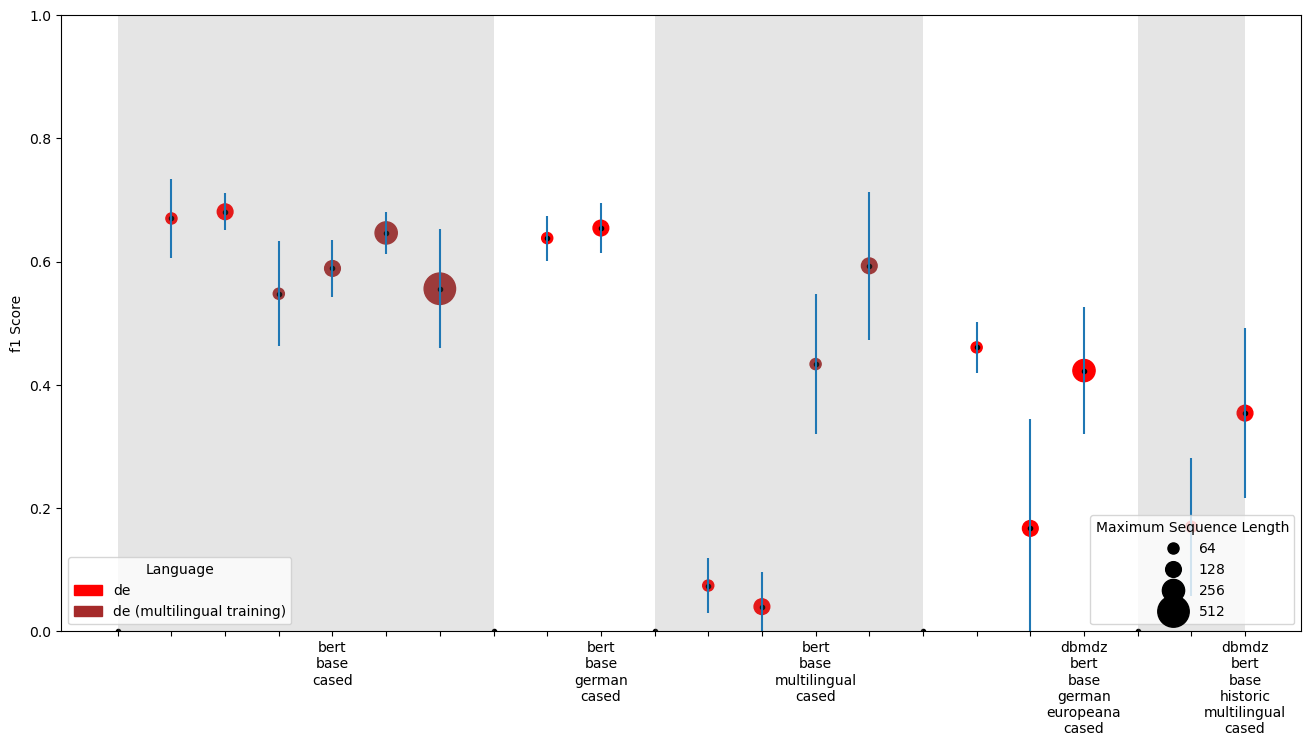

In [114]:
plot_results(grouped_ne_dev, ["de", "multilingual-de"])

/tmp/ipykernel_3702718/107887022.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


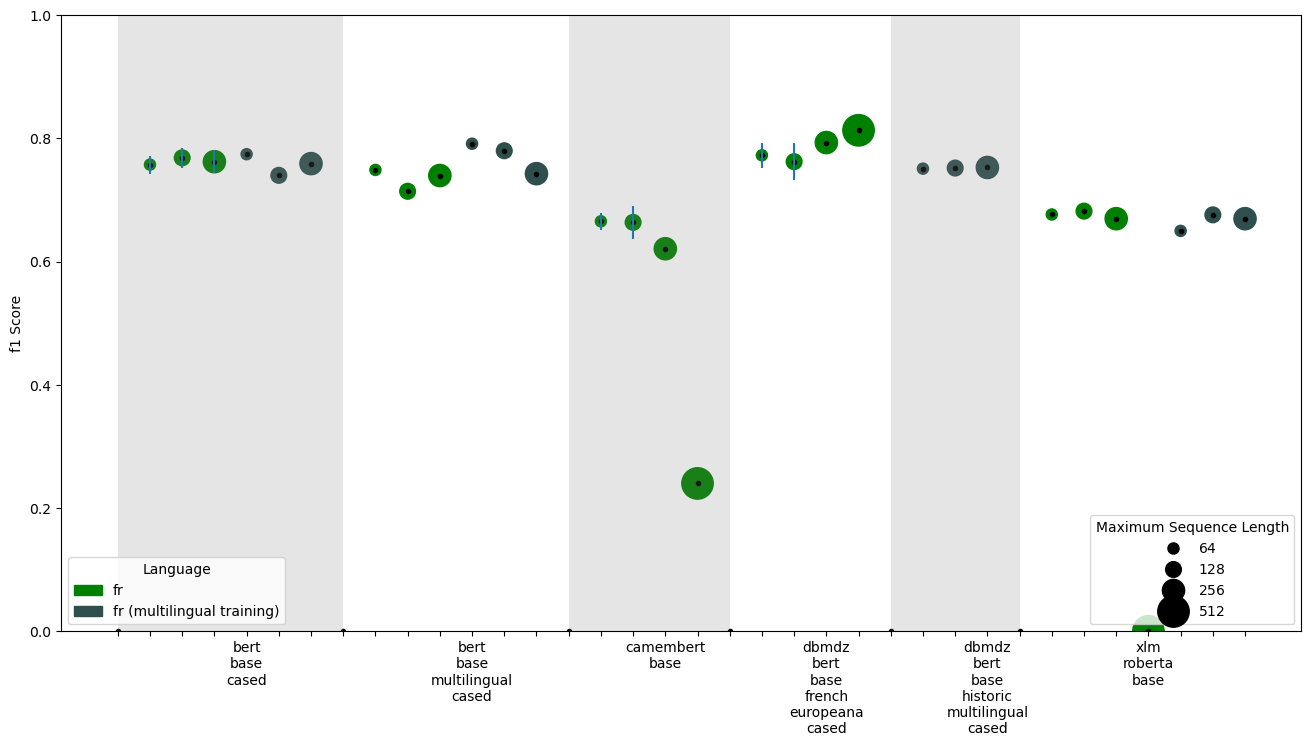

In [8]:
plot_results(grouped_ne_dev, ["fr", "multilingual-fr"])

### Test set

In [9]:
ne_test = ne_global_metrics.loc[(ne_global_metrics["set"]=="test") &
                                    ne_global_metrics["run"].notna()]
grouped_ne_test = ne_test.groupby(["model", "language", "max_sequence_length"]).agg({"run": "count", "f1": [np.mean, np.std]}).reset_index()
grouped_ne_test

model         language max_sequence_length   run        f1  \
                                                          count      mean   
0    bert_base_cased               de                  64     5  0.848716   
1    bert_base_cased               de                 128     5  0.842078   
2    bert_base_cased               de                 256     5  0.759259   
3    bert_base_cased               de                 512     5  0.782609   
4    bert_base_cased               fr                  64     5  0.752789   
..               ...              ...                 ...   ...       ...   
59  xlm_roberta_base  multilingual-de                 128     5  0.800000   
60  xlm_roberta_base  multilingual-de                 256     5  0.776699   
61  xlm_roberta_base  multilingual-fr                  64     5  0.676580   
62  xlm_roberta_base  multilingual-fr                 128     5  0.678700   
63  xlm_roberta_base  multilingual-fr                 256     5  0.664311   

              
         std  
0   0.013136  
1   0.028468  
2   0.000000  
3   0.000000  
4   0.027616  
..       ...  
59  0.000000  
60  0.000000  
61  0.000000  
62  0.000000  
63  0.000000  

[64 rows x 6 columns]

/tmp/ipykernel_3702718/107887022.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


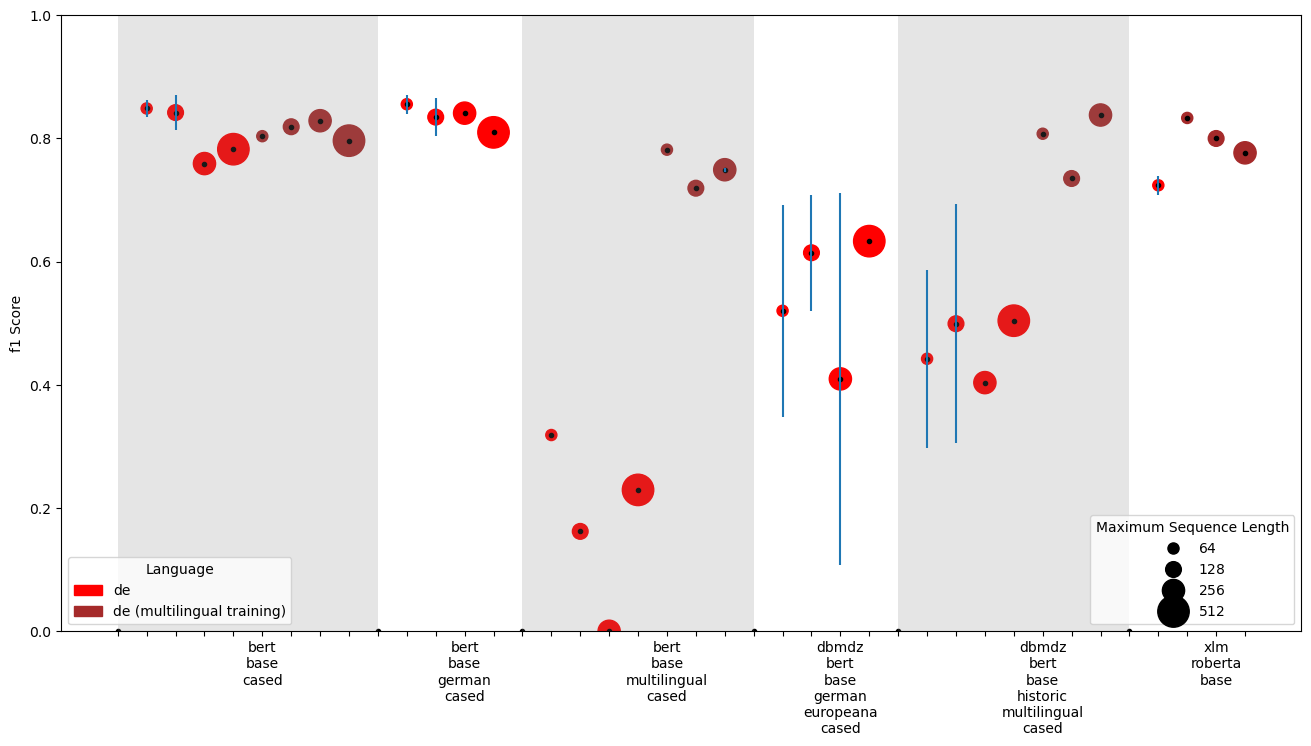

In [10]:
plot_results(grouped_ne_test, ["de", "multilingual-de"])

/tmp/ipykernel_3702718/107887022.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


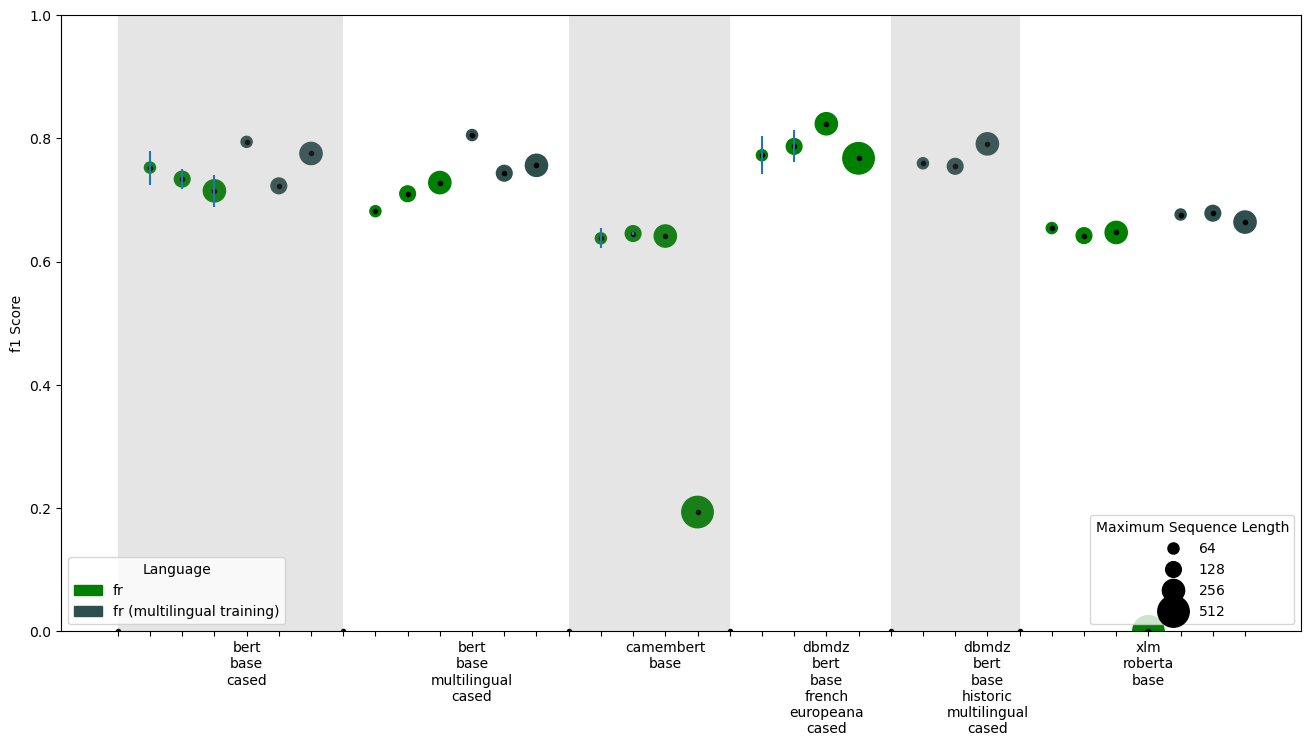

In [11]:
plot_results(grouped_ne_test, ["fr", "multilingual-fr"])

## Sentence-Level Classification

In [12]:
METRICS_LABELS = ["0", "1", "macro_avg", "accuracy"]
sent_global_metrics = pd.DataFrame()

for model in sent_test_metrics:
    dev_metrics = sent_dev_metrics[model]
    test_metrics = sent_test_metrics[model]
    chosen_dev_metrics = dev_metrics[dev_metrics["label"].isin(METRICS_LABELS)] 
    chosen_dev_metrics.insert(0, "set", "dev")
    chosen_test_metrics = test_metrics[test_metrics["label"].isin(METRICS_LABELS)] 
    chosen_test_metrics.insert(0, "set", "test")

    #add model specifications at beginning of dataframe
    for i, items in enumerate(parse_model_name(model).items()):
        col, value = items
        chosen_dev_metrics.insert(i, col, value)
        chosen_test_metrics.insert(i, col, value)
    
    #save all in DataFrame
    sent_global_metrics = pd.concat([sent_global_metrics, chosen_dev_metrics, chosen_test_metrics])

#only get later experiments
sent_global_metrics = sent_global_metrics[sent_global_metrics["run"].notna()]
#for micro_avg, accuracy=precision=recall
sent_global_metrics = sent_global_metrics.replace("_", None).fillna(method="backfill", axis=1)

sent_global_metrics[["max_sequence_length", "epochs"]] = sent_global_metrics[["max_sequence_length", "epochs"]].astype(int)
sent_global_metrics[["precision", "recall", "f1"]] = sent_global_metrics[["precision", "recall", "f1"]].astype(float)

In [13]:
sent_dev = sent_global_metrics[(sent_global_metrics["set"] == "dev") &
                                (sent_global_metrics["label"].isin(["0", "accuracy", "macro_avg"]))]
grouped_sent_dev = sent_dev.groupby(["model", "language", "max_sequence_length", "label"]).agg({"run": "count", "f1": [np.mean, np.std]}).reset_index()
grouped_sent_dev

model         language max_sequence_length      label   run  \
                                                                      count   
0     bert_base_cased               de                  64          0     5   
1     bert_base_cased               de                  64   accuracy     5   
2     bert_base_cased               de                  64  macro_avg     5   
3     bert_base_cased               de                 128          0     5   
4     bert_base_cased               de                 128   accuracy     5   
..                ...              ...                 ...        ...   ...   
187  xlm_roberta_base  multilingual-fr                 128   accuracy     5   
188  xlm_roberta_base  multilingual-fr                 128  macro_avg     5   
189  xlm_roberta_base  multilingual-fr                 256          0     5   
190  xlm_roberta_base  multilingual-fr                 256   accuracy     5   
191  xlm_roberta_base  multilingual-fr                 256  macro_avg     5   

          f1            
        mean       std  
0    0.71038  0.045029  
1    0.98642  0.003143  
2    0.85170  0.023310  
3    0.73864  0.039615  
4    0.98814  0.002323  
..       ...       ...  
187  0.98910  0.000000  
188  0.92080  0.000000  
189  0.79210  0.000000  
190  0.98520  0.000000  
191  0.89220  0.000000  

[192 rows x 7 columns]

/tmp/ipykernel_3702718/107887022.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


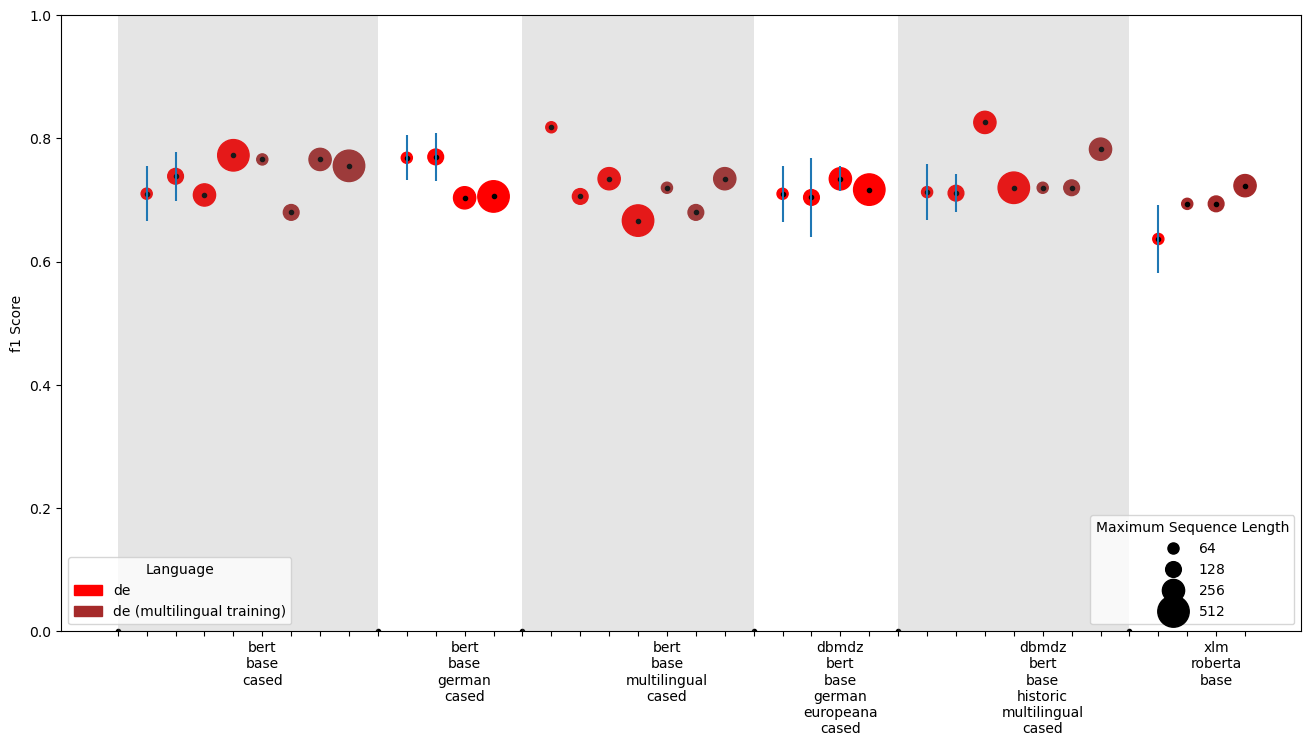

In [14]:
plot_results(grouped_sent_dev[grouped_sent_dev["label"]=="0"], ["de", "multilingual-de"])

/tmp/ipykernel_3702718/107887022.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


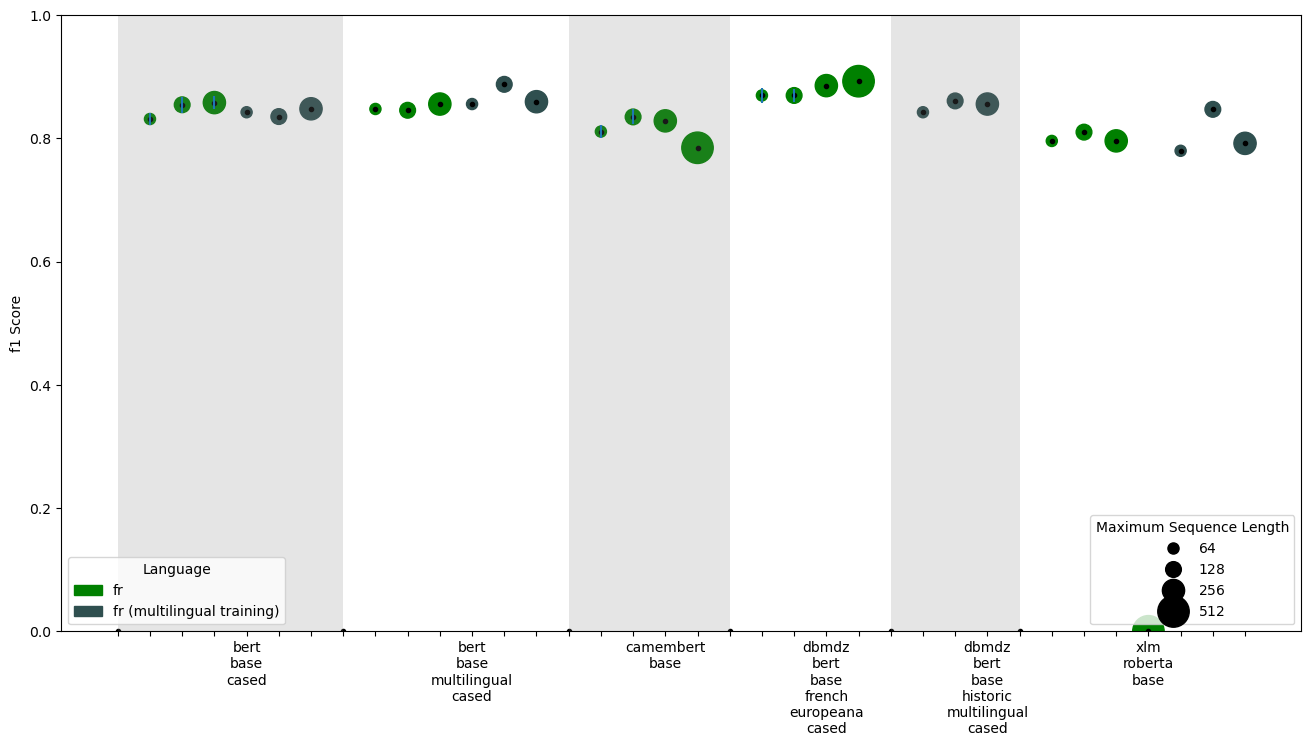

In [15]:
plot_results(grouped_sent_dev[grouped_sent_dev["label"]=="0"], ["fr", "multilingual-fr"])

In [16]:
sent_test = sent_global_metrics[(sent_global_metrics["set"] == "test") &
                                (sent_global_metrics["label"].isin(["accuracy", "macro_avg"]))]
grouped_sent_test = sent_test.groupby(["model", "language", "max_sequence_length", "label"]).agg({"run": "count", "f1": [np.mean, np.std]}).reset_index()
grouped_sent_test

model         language max_sequence_length      label   run  \
                                                                      count   
0     bert_base_cased               de                  64   accuracy     5   
1     bert_base_cased               de                  64  macro_avg     5   
2     bert_base_cased               de                 128   accuracy     5   
3     bert_base_cased               de                 128  macro_avg     5   
4     bert_base_cased               de                 256   accuracy     5   
..                ...              ...                 ...        ...   ...   
123  xlm_roberta_base  multilingual-fr                  64  macro_avg     5   
124  xlm_roberta_base  multilingual-fr                 128   accuracy     5   
125  xlm_roberta_base  multilingual-fr                 128  macro_avg     5   
126  xlm_roberta_base  multilingual-fr                 256   accuracy     5   
127  xlm_roberta_base  multilingual-fr                 256  macro_avg     5   

          f1            
        mean       std  
0    0.98440  0.001208  
1    0.91484  0.006019  
2    0.98496  0.001220  
3    0.91900  0.003991  
4    0.98420  0.000000  
..       ...       ...  
123  0.91410  0.000000  
124  0.98300  0.000000  
125  0.90580  0.000000  
126  0.98230  0.000000  
127  0.90190  0.000000  

[128 rows x 7 columns]

# HIPE Scorer

In [17]:
def import_HIPE_results(times=["TIME-ALL"], noise_levels=["LED-ALL"], set="dev", metrics=["F1_micro", "F1_macro_doc"], suffix="_time_noise"):
    df = pd.DataFrame()

    for model in os.listdir(MODEL_OUTPUT):
        model_path = os.path.join(MODEL_OUTPUT, model)
        #exclude files and early experiments
        if not os.path.isdir(model_path):
            continue
        if not "run" in model:
            continue
        
        json_files = [ x for x in os.listdir(os.path.join(MODEL_OUTPUT, model)) if f"pred_nerc_fine{suffix}.json" in x ]
        #continue if no nerc_fine predictions in experiments folder
        if not json_files:
            continue
        try:
            json_test_file = [x for x in json_files if set in x][0]
        except:
            print(f"No {set} file in {model}, but:", json_files)
            continue

        #get the data    
        with open(os.path.join(model_path, json_test_file), "r") as f:
            model_res = json.load(f)

        #collect the results
        res_dict = {"time": [], "noise_level": []}
        res_dict.update({metric: [] for metric in metrics})

        
        for time in times:
            for noise_level in noise_levels:
                res_dict["time"].append(time)
                res_dict["noise_level"].append(noise_level)
                for metric in metrics:
                    try:
                        res_dict[metric].append(model_res["NE-FINE-LIT"][time][noise_level]["ALL"]["ent_type"][metric])
                    except:
                        print("Could not retrive results for model:", model)
                        if len(model_res["NE-FINE-LIT"].keys()) >1:
                            print("Keys present:", model_res["NE-FINE-LIT"].keys())
                        continue
        #parse modelname
        modelname_df = pd.DataFrame(parse_model_name(model), index=[0])  
        modelname_df = pd.concat([modelname_df]*len(times)*len(noise_levels), ignore_index=True)
        
        #concat modelname and results and add dataframe to overall df
        try:
            cur_df = pd.concat([modelname_df, pd.DataFrame(res_dict)], axis=1)
            df = pd.concat([df, cur_df], ignore_index=True)
        except:
            #print("NO RESULTS", model)
            pass
    df["max_sequence_length"] = df["max_sequence_length"].astype(int)
    df["epochs"] = df["epochs"].astype(int)
    df = df.sort_values(by=["model", "max_sequence_length", "suffix"])

    return df


In [18]:
ne_HIPE = import_HIPE_results(suffix="")
grouped_ne_HIPE = ne_HIPE.groupby(["model", "language", "max_sequence_length"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std]}
     ).reset_index()

grouped_ne_HIPE

model language max_sequence_length  \
                                                                               
0                               bert_base_cased       de                  64   
1                               bert_base_cased       de                 128   
2                               bert_base_cased       de                 256   
3                               bert_base_cased       de                 512   
4                               bert_base_cased       fr                  64   
5                               bert_base_cased       fr                 128   
6                               bert_base_cased       fr                 256   
7                        bert_base_german_cased       de                  64   
8                        bert_base_german_cased       de                 128   
9                        bert_base_german_cased       de                 256   
10                       bert_base_german_cased       de                 512   
11                 bert_base_multilingual_cased       de                  64   
12                 bert_base_multilingual_cased       de                 128   
13                 bert_base_multilingual_cased       de                 256   
14                 bert_base_multilingual_cased       de                 512   
15                 bert_base_multilingual_cased       fr                  64   
16                 bert_base_multilingual_cased       fr                 128   
17                 bert_base_multilingual_cased       fr                 256   
18                               camembert_base       fr                  64   
19                               camembert_base       fr                 128   
20                               camembert_base       fr                 256   
21                               camembert_base       fr                 512   
22       dbmdz_bert_base_french_europeana_cased       fr                  64   
23       dbmdz_bert_base_french_europeana_cased       fr                 128   
24       dbmdz_bert_base_french_europeana_cased       fr                 256   
25       dbmdz_bert_base_french_europeana_cased       fr                 512   
26       dbmdz_bert_base_german_europeana_cased       de                  64   
27       dbmdz_bert_base_german_europeana_cased       de                 128   
28       dbmdz_bert_base_german_europeana_cased       de                 256   
29       dbmdz_bert_base_german_europeana_cased       de                 512   
30  dbmdz_bert_base_historic_multilingual_cased       de                  64   
31  dbmdz_bert_base_historic_multilingual_cased       de                 128   
32  dbmdz_bert_base_historic_multilingual_cased       de                 256   
33  dbmdz_bert_base_historic_multilingual_cased       de                 512   
34  dbmdz_bert_base_historic_multilingual_cased       fr                  64   
35  dbmdz_bert_base_historic_multilingual_cased       fr                 128   
36  dbmdz_bert_base_historic_multilingual_cased       fr                 256   
37                             xlm_roberta_base       de                  64   
38                             xlm_roberta_base       de                 128   
39                             xlm_roberta_base       de                 256   
40                             xlm_roberta_base       fr                  64   
41                             xlm_roberta_base       fr                 128   
42                             xlm_roberta_base       fr                 256   
43                             xlm_roberta_base       fr                 512   

     run  F1_micro           F1_macro_doc            
   count      mean       std         mean       std  
0      5  0.684025  0.055929     0.943111  0.003246  
1      5  0.701379  0.032887     0.944296  0.023793  
2      5  0.700000  0.000000     0.940741  0.000000  
3      5  0.638298  0.000000     0.940741  0.000000  
4      5  0.757078  0.020548     0.90

/tmp/ipykernel_3702718/107887022.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


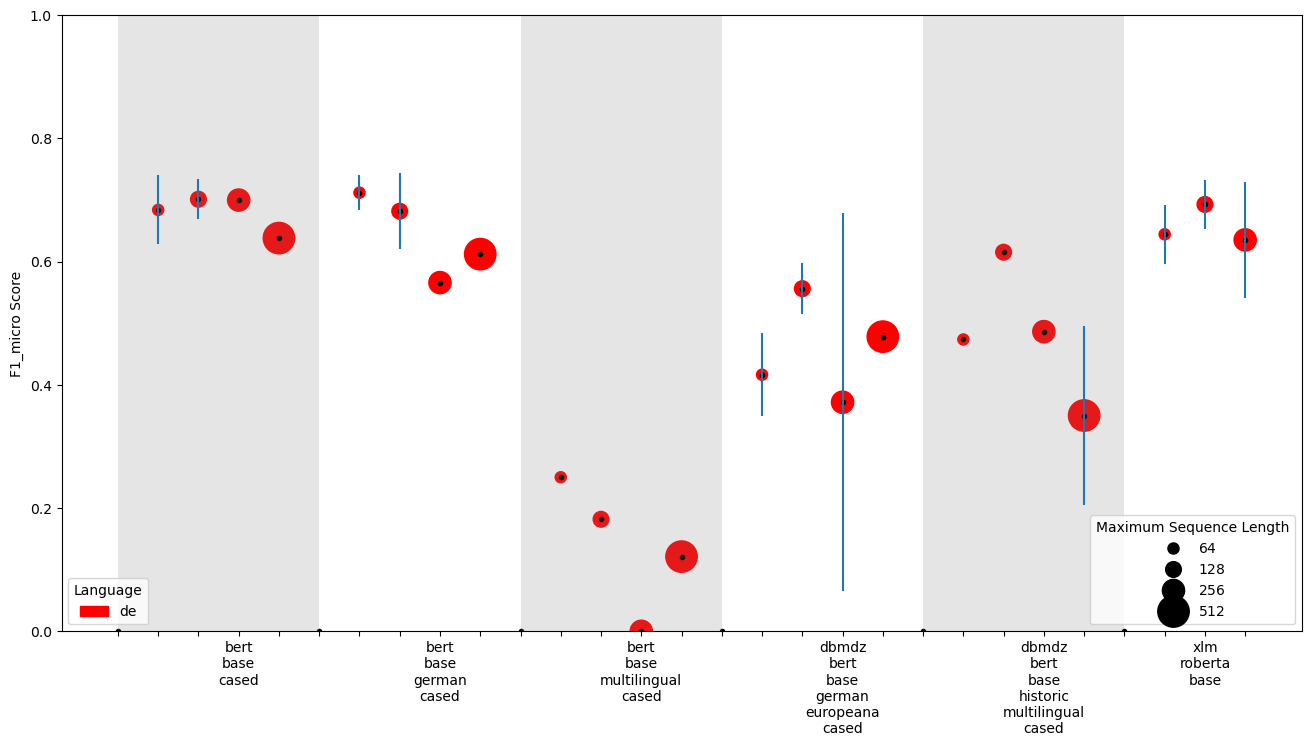

In [19]:
plot_results(grouped_ne_HIPE, languages=["de"], score="F1_micro")

/tmp/ipykernel_3702718/107887022.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


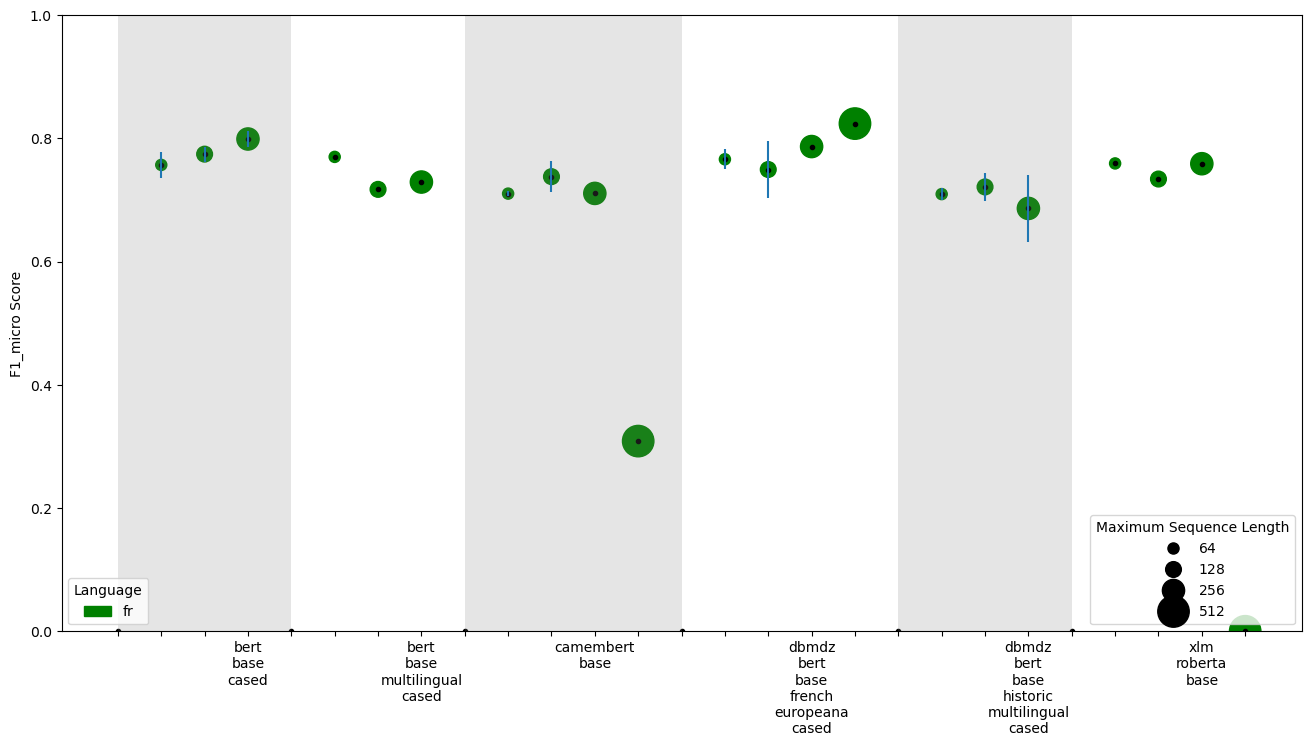

In [20]:
plot_results(grouped_ne_HIPE, languages=["fr"], score="F1_micro")

## Noise and Time levels

In [116]:
NOISE_LEVELS = ["LED-0.0-0.0", "LED-0.001-0.1", "LED-0.1-0.3", "LED-0.3-1.1"]
TIME_LEVELS = ["TIME-1800-1900", "TIME-1900-1940", "TIME-1940-2000"]

In [308]:
def stem_plot_results(orig_df, title, languages=["de"], split_by="time", levels=TIME_LEVELS, metric="F1_micro", 
                      reverse_levels=False, add_count=False):
    """  
    Stem Plot to plot results split by noise and time levels.
    """
    #only keep rows which have at least one annotation
    df_copy = orig_df.copy()
    df_copy["counts"] = df_copy["TP"]["sum"] + df_copy["FN"]["sum"]
    not_na = df_copy[df_copy["counts"] > 0]

    lang_df = not_na[not_na["language"].isin(languages)]

    # define general marker forms and colors
    markers = dict(zip(list(range(4)), ["o", "D", "p", "*"]))
    colors = dict(zip(list(range(4)), ["b", "g", "c", "m"]))

    # instantiate plot
    fig, ax = plt.subplots(figsize=(12,8))

    # plotting aesthetics
    if reverse_levels:
        levels = reversed(levels)
        
    # for each split, plot a stem plot, all on top of each other, with different markers
    for i, split in enumerate(levels):
        df = lang_df[lang_df[split_by]==split]
        if df.empty:
            continue
        y = df["model"].str.cat(df[["language", "max_sequence_length"]].values.astype(str),sep='-|-')
        x = df[metric]["mean"]

        ax.stem(y, x, orientation="horizontal", basefmt="grey", markerfmt=markers[i], linefmt=colors[i], label=split)

        if add_count:
            for k,j, count in zip(x,y, df["counts"]):
                offset = 0 # -15 + 15*i
                ax.annotate(str(count),xy=(k,j), xytext=(offset,5), textcoords='offset points')

    # legend
    ax.legend()
    ax.set_xlabel(metric)
    ax.set_title(title)
    
    plt.show()

In [309]:
time_dev_HIPE = import_HIPE_results(times=TIME_LEVELS, suffix="_time_noise", metrics=["F1_micro", "F1_macro_doc", "TP", "FN"])
grouped_time_dev_HIPE = time_dev_HIPE.groupby(["model", "language", "max_sequence_length", "time"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std],
     "TP": "sum", "FN": "sum"}
     ).reset_index()
grouped_time_dev_HIPE

model language max_sequence_length            time   run  \
                                                                   count   
0     bert_base_cased       de                  64  TIME-1800-1900     5   
1     bert_base_cased       de                  64  TIME-1900-1940     5   
2     bert_base_cased       de                  64  TIME-1940-2000     5   
3     bert_base_cased       de                 128  TIME-1800-1900     5   
4     bert_base_cased       de                 128  TIME-1900-1940     5   
..                ...      ...                 ...             ...   ...   
127  xlm_roberta_base       fr                 256  TIME-1900-1940     5   
128  xlm_roberta_base       fr                 256  TIME-1940-2000     5   
129  xlm_roberta_base       fr                 512  TIME-1800-1900     5   
130  xlm_roberta_base       fr                 512  TIME-1900-1940     5   
131  xlm_roberta_base       fr                 512  TIME-1940-2000     5   

     F1_micro           F1_macro_doc             TP   FN  
         mean       std         mean       std  sum  sum  
0    0.000000  0.000000          NaN       NaN    0    5  
1    0.444623  0.093529     0.900000  0.015215   22    8  
2    0.916667  0.000000     0.966667  0.000000   55   10  
3    0.000000  0.000000          NaN       NaN    0    5  
4    0.466667  0.049372     0.905556  0.060858   22    8  
..        ...       ...          ...       ...  ...  ...  
127  0.814815  0.000000     0.922161  0.000000  110   25  
128  0.757895  0.000000     0.885333  0.000000  180   65  
129  0.000000  0.000000          NaN       NaN    0   50  
130  0.000000  0.000000          NaN       NaN    0  135  
131  0.000000  0.000000          NaN       NaN    0  245  

[132 rows x 11 columns]

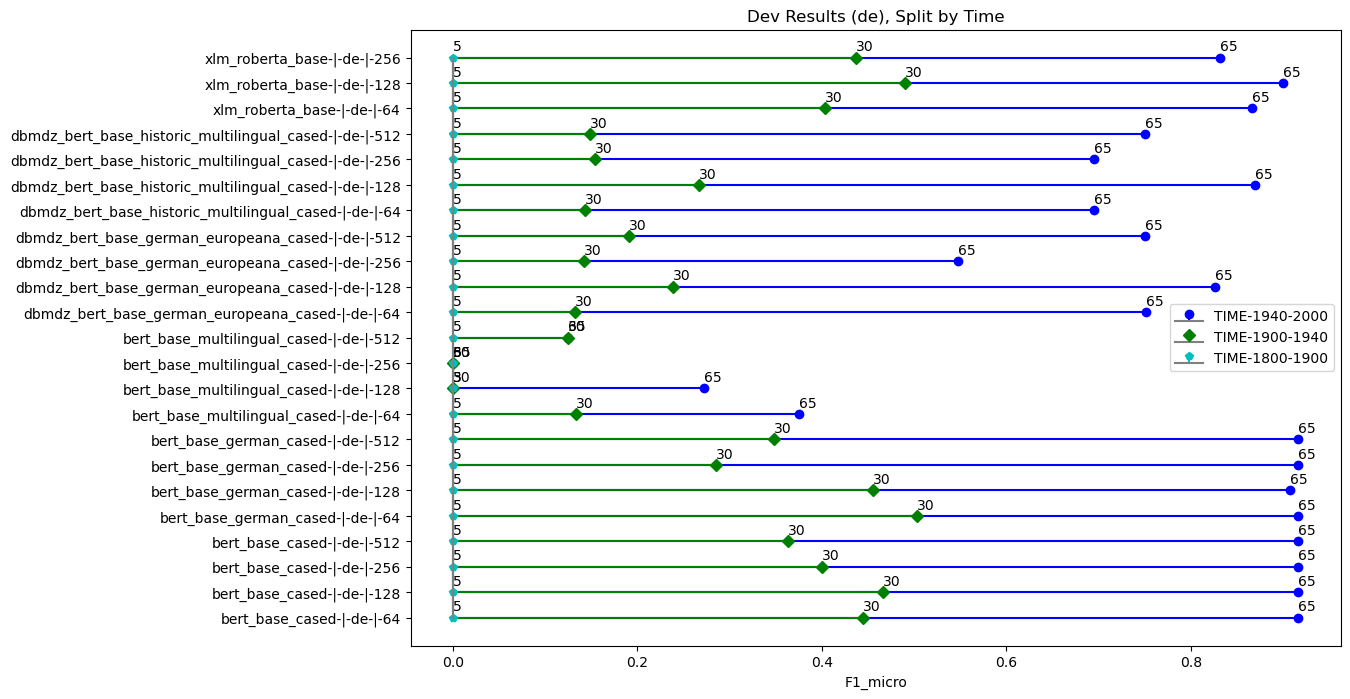

In [310]:
stem_plot_results(grouped_time_dev_HIPE, title="Dev Results (de), Split by Time", reverse_levels=True, add_count=True)

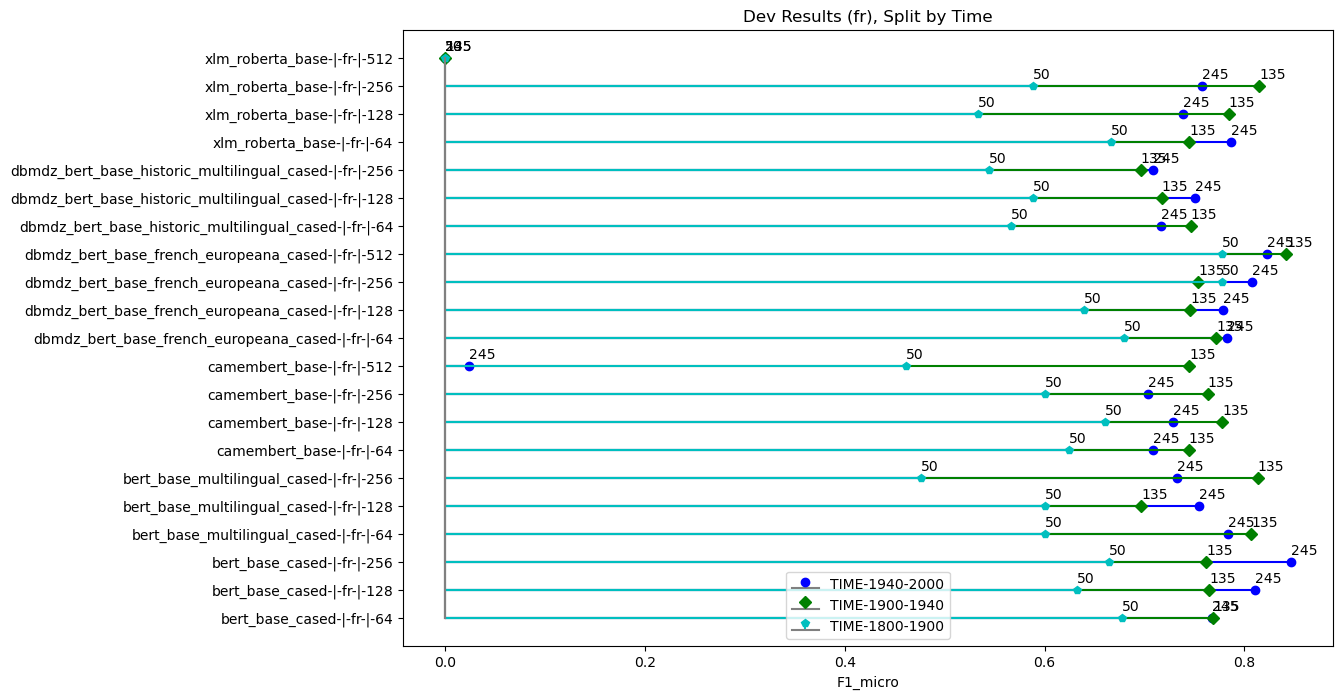

In [311]:
stem_plot_results(grouped_time_dev_HIPE, title="Dev Results (fr), Split by Time", languages=["fr"], reverse_levels=True, add_count=True)

In [312]:
noise_dev_HIPE = import_HIPE_results(noise_levels=NOISE_LEVELS, suffix="_time_noise", metrics=["F1_micro", "F1_macro_doc", "TP", "FN"])
grouped_noise_dev_HIPE = noise_dev_HIPE.groupby(["model", "language", "max_sequence_length", "noise_level"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std],
     "TP": "sum", "FN": "sum"}
     ).reset_index()
grouped_noise_dev_HIPE

model language max_sequence_length    noise_level   run  \
                                                                  count   
0     bert_base_cased       de                  64    LED-0.0-0.0     5   
1     bert_base_cased       de                  64  LED-0.001-0.1     5   
2     bert_base_cased       de                  64    LED-0.1-0.3     5   
3     bert_base_cased       de                  64    LED-0.3-1.1     5   
4     bert_base_cased       de                 128    LED-0.0-0.0     5   
..                ...      ...                 ...            ...   ...   
171  xlm_roberta_base       fr                 256    LED-0.3-1.1     5   
172  xlm_roberta_base       fr                 512    LED-0.0-0.0     5   
173  xlm_roberta_base       fr                 512  LED-0.001-0.1     5   
174  xlm_roberta_base       fr                 512    LED-0.1-0.3     5   
175  xlm_roberta_base       fr                 512    LED-0.3-1.1     5   

     F1_micro           F1_macro_doc            TP   FN  
         mean       std         mean       std sum  sum  
0    0.678478  0.053392     0.929778  0.015012  72   18  
1    0.000000  0.000000          NaN       NaN   0    0  
2    0.000000  0.000000          NaN       NaN   0    5  
3    0.197436  0.053716     1.000000  0.000000   5    0  
4    0.706738  0.042673     0.943556  0.027128  73   17  
..        ...       ...          ...       ...  ..  ...  
171  0.000000  0.000000          NaN       NaN   0    0  
172  0.000000  0.000000          NaN       NaN   0  410  
173  0.000000  0.000000          NaN       NaN   0    5  
174  0.000000  0.000000          NaN       NaN   0   15  
175  0.000000  0.000000          NaN       NaN   0    0  

[176 rows x 11 columns]

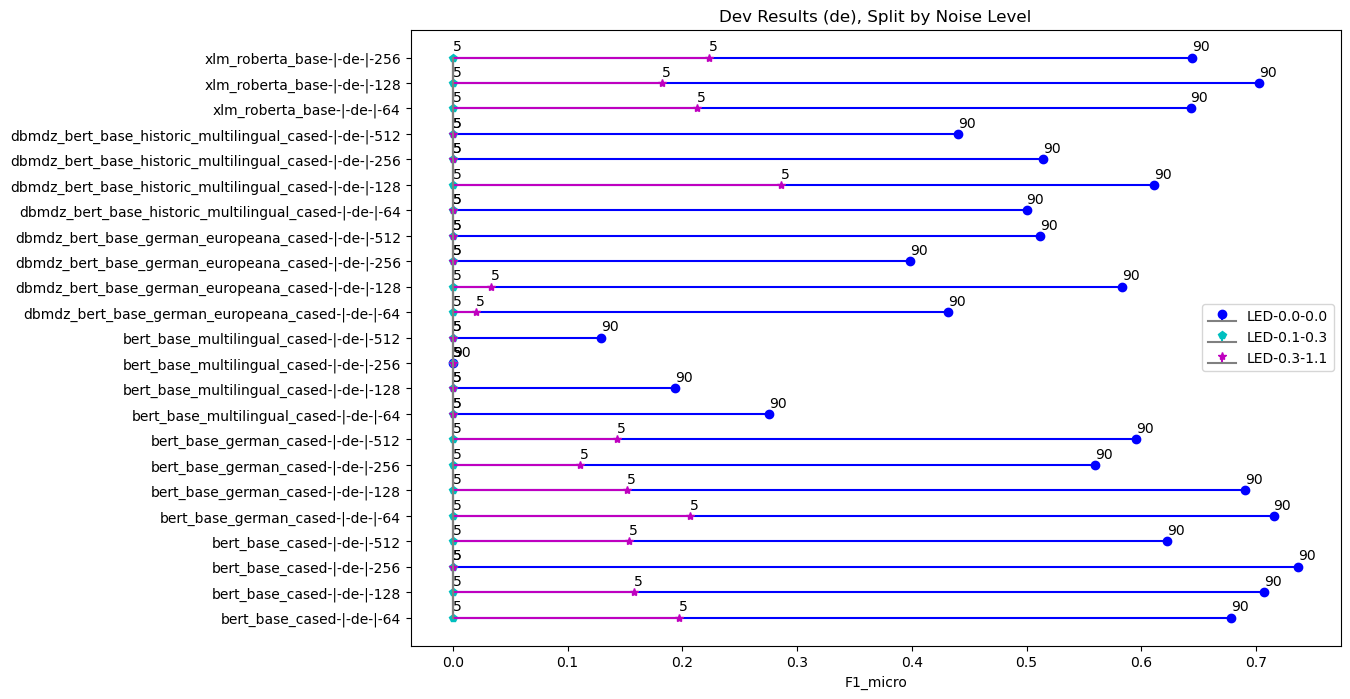

In [313]:
stem_plot_results(grouped_noise_dev_HIPE, title="Dev Results (de), Split by Noise Level", split_by="noise_level", 
                  levels=NOISE_LEVELS, add_count=True)

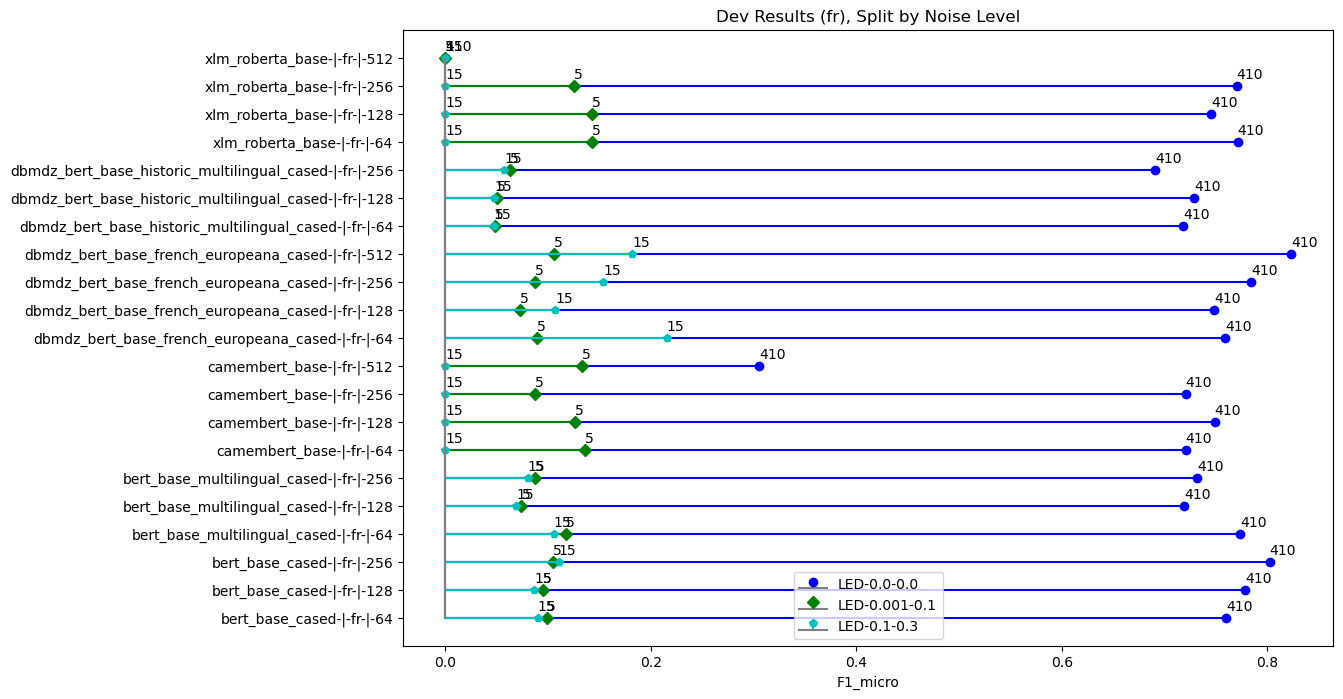

In [314]:
stem_plot_results(grouped_noise_dev_HIPE, title="Dev Results (fr), Split by Noise Level", languages=["fr"], split_by="noise_level", 
                  levels=NOISE_LEVELS, add_count=True)

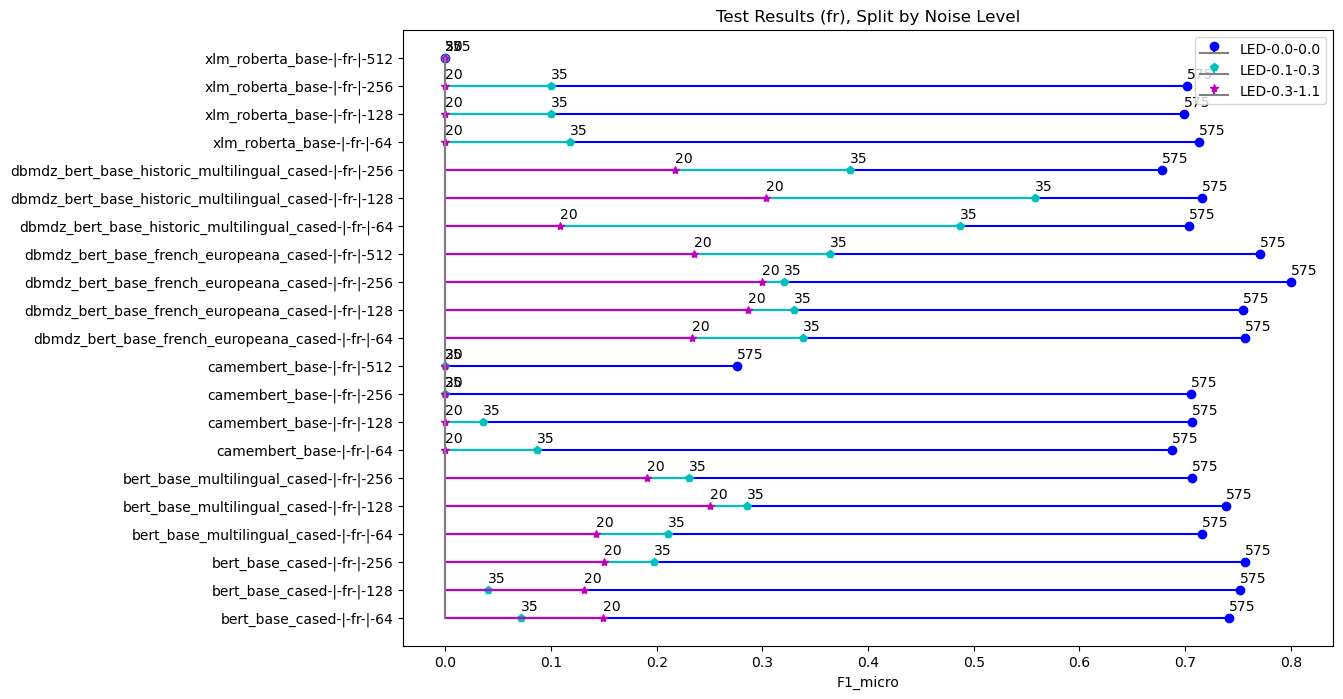

In [315]:
noise_test_HIPE = import_HIPE_results(noise_levels=NOISE_LEVELS, suffix="_time_noise", set="test", metrics=["F1_micro", "F1_macro_doc", "TP", "FN"])
grouped_noise_test_HIPE = noise_test_HIPE.groupby(["model", "language", "max_sequence_length", "noise_level"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std],
     "TP": "sum", "FN": "sum"}
     ).reset_index()
stem_plot_results(grouped_noise_test_HIPE, title="Test Results (fr), Split by Noise Level", languages=["fr"], split_by="noise_level", 
                  levels=NOISE_LEVELS, add_count=True)

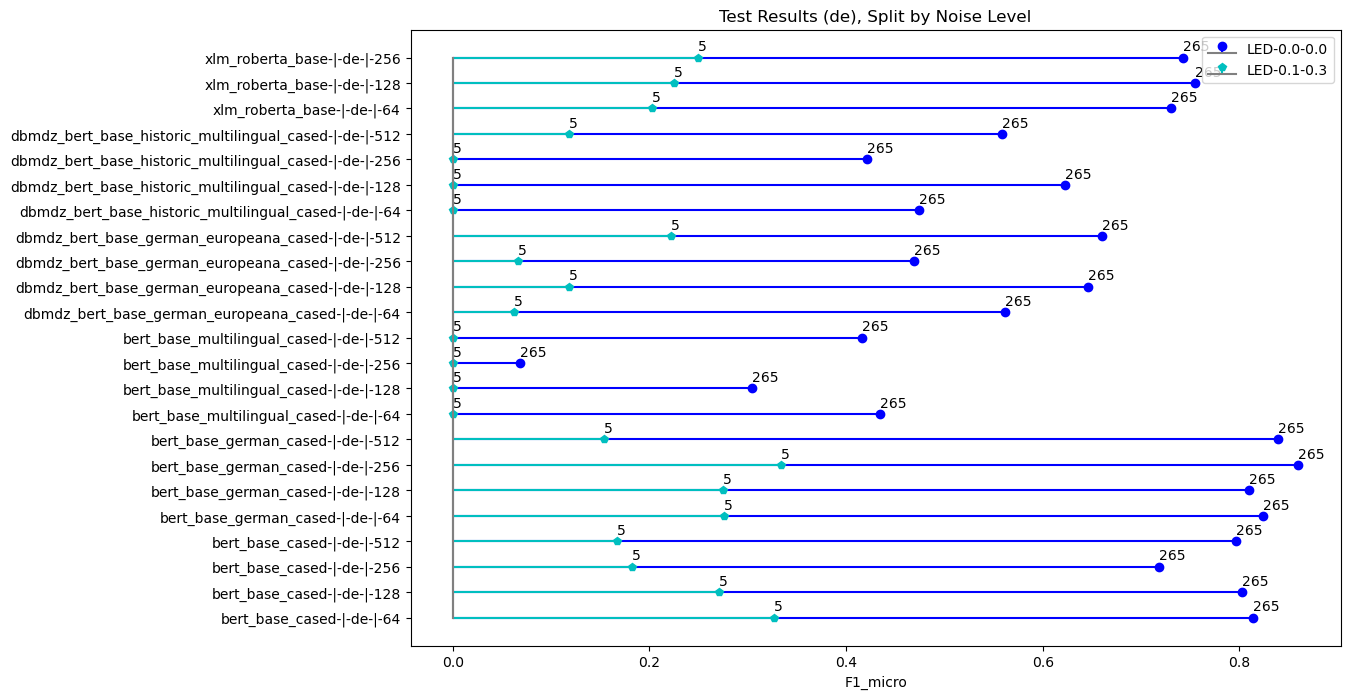

In [316]:
stem_plot_results(grouped_noise_test_HIPE, title="Test Results (de), Split by Noise Level", languages=["de"], split_by="noise_level", 
                  levels=NOISE_LEVELS, add_count=True)

## Save evaluation data

### Metrics to pickle

In [29]:
ne_global_metrics.to_pickle(os.path.join(MODEL_OUTPUT, "NE_metrics.pkl"))
sent_global_metrics.to_pickle(os.path.join(MODEL_OUTPUT, "Sent_metrics.pkl"))

In [30]:
with open(os.path.join(MODEL_OUTPUT, 'NE_all_test_metrics.pkl'), 'wb') as f:
    pickle.dump(ne_test_metrics, f)

with open(os.path.join(MODEL_OUTPUT, 'Sent_all_test_metrics.pkl'), 'wb') as f:
    pickle.dump(sent_test_metrics, f)

### combine all result files in one zip folder

In [65]:
RESULTS_DIR = "results"

#get all models
models = [doc for doc in os.listdir(MODEL_OUTPUT) 
          if os.path.isdir(os.path.join(MODEL_OUTPUT,doc))]


for model in models: 
    #get all results of form "all_results_{de, fr}.json" and "newsagency-data..._pred.tsv"
    results_to_save = [doc for doc in os.listdir(os.path.join(MODEL_OUTPUT, model)) if ("all_results" in doc) or (".tsv" in doc)]
    if results_to_save:
        #copy files to new directory
        os.makedirs(os.path.join(RESULTS_DIR, model), exist_ok=True)
        for result in results_to_save:
            shutil.copyfile(os.path.join(MODEL_OUTPUT, model, result), os.path.join(RESULTS_DIR, model, result))
        print(f"Saved {results_to_save} in folder {os.path.join(RESULTS_DIR, model)}")

#make a zipfile out of results directory
print(f"Make zipfile of {RESULTS_DIR}")
shutil.make_archive("results", 'zip', "results")
print(f"Done")

Saved ['newsagency-data-2-dev-de_pred.tsv', 'newsagency-data-2-test-de_pred.tsv', 'all_results.json'] in folder results/model_bert_base_german_cased_max_sequence_length_128_epochs_3_run_de_2
Saved ['newsagency-data-2-dev-de_pred.tsv', 'newsagency-data-2-test-de_pred.tsv'] in folder results/model_xlm_roberta_base_max_sequence_length_256_epochs_3_run_de_4
Saved ['newsagency-data-2-test-fr_pred.tsv', 'newsagency-data-2-dev-fr_pred.tsv', 'all_results.json'] in folder results/model_bert_base_cased_max_sequence_length_64_epochs_3_run_fr_1
Saved ['newsagency-data-2-dev-de_pred.tsv', 'newsagency-data-2-test-de_pred.tsv', 'all_results.json'] in folder results/model_bert_base_cased_max_sequence_length_128_epochs_3_run_de_5
Saved ['newsagency-data-2-test-fr_pred.tsv', 'newsagency-data-2-dev-fr_pred.tsv', 'all_results.json'] in folder results/model_camembert_base_max_sequence_length_64_epochs_3_run_fr_3
Saved ['newsagency-data-2-test-fr_pred.tsv', 'newsagency-data-2-dev-fr_pred.tsv', 'all_results_